# Tutorial2: generating synthetic ngEHT observations

---
This tutorial demonstrates synthesis of ngEHT measurements of a single orbiting hot-spot. EHT observations are simulated using [eht-imaging](https://github.com/achael/eht-imaging).

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import bhnerf
import ehtim as eh
from astropy import units
from bhnerf import constants as consts

/srv/tmp/kyle/miniconda3/envs/jax/lib/python3.9/site-packages/ehtim/__init__.py:56: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Welcome to eht-imaging! v 1.2.4 



In [2]:
"""
Generate an initial emission distribution (emission_0: 3D DataArray) with single Gaussian hotspot
"""
spin = 0.2
inclination = np.deg2rad(60)
fov_M = 16.0

emission_0 = bhnerf.emission.generate_hotspot_xr(
    resolution=(64, 64, 64), 
    rot_axis=[0.0, 0.0, 1.0], 
    rot_angle=0.0,
    orbit_radius=5.5,
    std=0.7,
    r_isco=bhnerf.constants.isco_pro(spin),
    fov=(fov_M, 'GM/c^2'),
)

In [3]:
"""
Visualization 3D volume (requires ipyvolume: https://ipyvolume.readthedocs.io/)
"""
bhnerf.visualization.ipyvolume_3d(emission_0, fov=fov_M, level=[0, 0.2, 0.7])

Container(children=[VBox(children=(HBox(children=(Label(value='levels:'), FloatSlider(value=0.0, max=1.0, step…

In [4]:
"""
Compute Kerr geodesics (photon trajectories) around the black hole starting at the image plane
"""
geos = bhnerf.kgeo.image_plane_geos(
    spin, inclination, 
    num_alpha=64, num_beta=64, 
    alpha_range=[-fov_M/2, fov_M/2],
    beta_range=[-fov_M/2, fov_M/2]
)

# Keplerian prograde velocity field
Omega = np.sign(spin + np.finfo(float).eps) * np.sqrt(geos.M) / (geos.r**(3/2) + geos.spin * np.sqrt(geos.M))

/srv/tmp/kyle/miniconda3/envs/jax/lib/python3.9/site-packages/xarray/core/computation.py:821: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


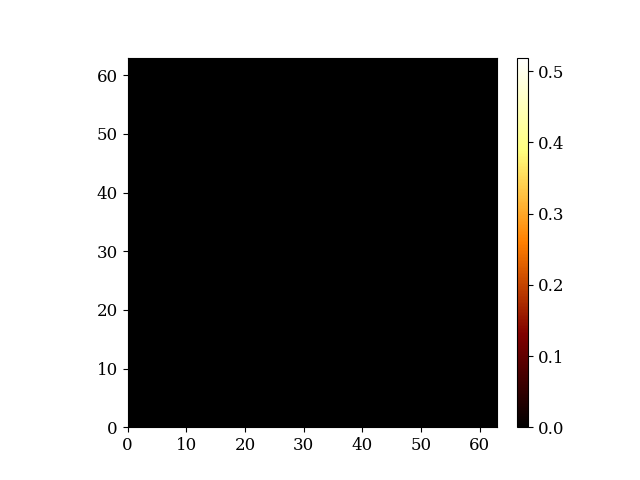

In [6]:
"""
Ray trace through the emission to simulate the image plane over 40.0 minutes and visualize image plane movie
t_frames: frame time in hrs 
t_injection: hotspot injection time (M) - needed for slow-light (light does not reach the sensor instantaneously) 
             Taking the distance of the image screen (-geos.r_o) gives an injection at the initial frame (approximately) 
"""
nt = 64
t_injection = -float(geos.r_o) 
t_frames = np.linspace(0.0, 40.0*units.min, nt)
image_plane = bhnerf.emission.image_plane_dynamics(emission_0, geos, Omega, t_frames, t_injection)

%matplotlib widget
movie_xr = xr.DataArray(image_plane, dims=['t', 'alpha', 'beta'])
movie_xr.visualize.animate(cmap='afmhot')

In [6]:
"""
Generate synthetic EHT obsertvations using eht-imaging library
"""
obs_params = {
    'mjd': 57851,                                 # night of april 6-7, 2017
    'timetype': 'GMST',
    'nt': nt,                                     # number of time samples 
    'tstart': 2.0 + t_frames[0].to('hr').value,   # start of observations
    'tstop': 2.0 + t_frames[-1].to('hr').value,   # end of observation 
    'tint': 30.0,                                 # integration time,
    'array': eh.array.load_txt('../eht_arrays/ngEHT.txt')
}
obs_empty = bhnerf.observation.empty_eht_obs(**obs_params)

# Pixel size in radians based on Sgr A* mass/distance
fov_rad = (fov_M * consts.GM_c2(consts.sgra_mass) / consts.sgra_distance.to('m')) * units.rad
psize = fov_rad.value / geos.alpha.size
obs_args = {'psize': psize, 'ra': obs_empty.ra, 'dec': obs_empty.dec, 'rf': obs_empty.rf, 'mjd': obs_empty.mjd}

# Scale image-plane values to `reasonable` fluxes  
flux_scaling = 0.01  
movie = eh.movie.Movie(flux_scaling*image_plane, times=t_frames.value, **obs_args)
obs = bhnerf.observation.observe_same(movie, obs_empty)

Producing clean visibilities from movie with nfft FT . . . 
Applying Jones Matrices to data . . . 
Adding thermal noise to data . . . 
Applying a priori calibration with estimated Jones matrices . . . 


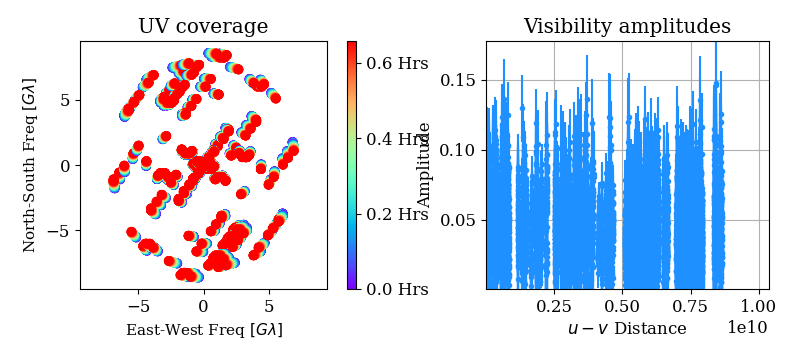

In [7]:
"""
Visualize coverage and visibility amplitudes
"""
%matplotlib widget
fig, ax = plt.subplots(1, 2, figsize=(8,3.5))
ax[0].set_title('UV coverage')
ax[1].set_title('Visibility amplitudes')
bhnerf.observation.plot_uv_coverage(obs_empty, ax=ax[0], cmap_ticks=[0,0.2, 0.4, 0.6], fontsize=11)
obs.plotall('uvdist', 'amp', axis=ax[1])
plt.tight_layout()

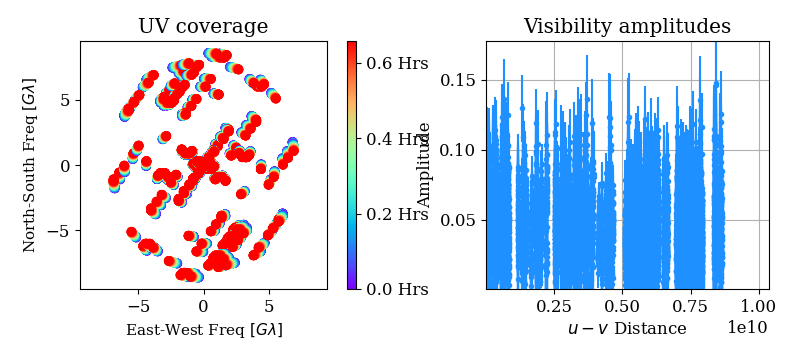

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(8,3.5))
ax[0].set_title('UV coverage')
ax[1].set_title('Visibility amplitudes')
bhnerf.observation.plot_uv_coverage(obs_empty, ax=ax[0], cmap_ticks=[0,0.2, 0.4, 0.6], fontsize=11)
obs.plotall('uvdist', 'amp', axis=ax[1])
plt.tight_layout()